# 1_基于LSTM的石油产量预测_单变量_基准模型

在这个代码库中，我们将使用 [Equinor Volve 数据集](https://www.equinor.com/energy/volve-data-sharing) 的生产数据，这是一个公开可用的地下数据集，来分别训练三个独立的模型，以预测石油、天然气和水的产量。

## 1 导入必要的库
每次运行代码时，都使用`random seed 42`来复制相同的随机数。

In [13]:
#引入相关模块
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
tf.random.set_seed(42)

## 2 探索性分析与数据预处理

### 2.1 读取数据

导入名为`Volve_production_data`的Excel文件，其中包含相关数据。

In [14]:
#读取数据
full_data = pd.read_excel('Volve_production_data.xlsx')
full_data

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15629,2016-09-14,NO 15/9-F-5 AH,5769,15/9-F-5,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.07776,0.22879,0.01862,0.0,0.0,0.0,NaN,production,OP
15630,2016-09-15,NO 15/9-F-5 AH,5769,15/9-F-5,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.08545,0.22914,0.00631,0.0,0.0,0.0,NaN,production,OP
15631,2016-09-16,NO 15/9-F-5 AH,5769,15/9-F-5,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.08544,0.22896,0.01181,0.0,0.0,0.0,NaN,production,OP
15632,2016-09-17,NO 15/9-F-5 AH,5769,15/9-F-5,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.07497,0.22846,0.02576,0.0,0.0,0.0,NaN,production,OP


#### 2.1.1 打印出所有列的名称

In [15]:
column_names = full_data.columns
print(column_names)

Index(['DATEPRD', 'WELL_BORE_CODE', 'NPD_WELL_BORE_CODE', 'NPD_WELL_BORE_NAME',
       'NPD_FIELD_CODE', 'NPD_FIELD_NAME', 'NPD_FACILITY_CODE',
       'NPD_FACILITY_NAME', 'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE',
       'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS',
       'AVG_CHOKE_SIZE_P', 'AVG_CHOKE_UOM', 'AVG_WHP_P', 'AVG_WHT_P',
       'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL',
       'BORE_WI_VOL', 'FLOW_KIND', 'WELL_TYPE'],
      dtype='object')


`Vovle`数据集有大约4万个文件，包括：
* 地球物理数据
* 地球科学资料
* 生产数据
* 报告
* 静态模型和动态模拟
* 地震资料
* 测井
* 井技术数据
* 实时钻井数据

为了优化模型性能，必须从数据集中提取所有相关特征。这涉及空间（静态）和时间（动态）数据。例如，从地面作业条件（Surface Operational Conditions）、所有井的详细结构（Details of all Wells Architecture）、测井（Well Logs）、岩心分析（Core Analysis）、试井（Well Tests）、地震（Seismic）、生产测井（Production Logs）、温度测量（Temperature Survey）、生产/注入历史（Production/Injection History）等方面提取特征，建立综合油藏模型。

然而，特征提取本身就是一个全面的主题，为了这个讨论的目的，我们的重点是机器学习（ML）方面，而不是深入研究特征提取。因此，我们将只使用动态（生产）数据，如：`ON_STREAM_HRS, AVG_DOWNHOLE_PRESSURE, AVG_DOWNHOLE_TEMPERATURE, AVG_DP_TUBING, AVG_ANNULUS_PRESS, AVG_CHOKE_SIZE_P, AVG_CHOKE_UOM, AVG_WHP_P, AVG_WHT_P, DP_CHOKE_SIZE,`和`BORE_OIL_VOL`来训练我们的LSTM模型。




In [16]:
unique_well_bore = full_data['NPD_WELL_BORE_NAME'].unique()
print("All Unique Well Bore Names:")
print(unique_well_bore)

unique_producer_well_bore = full_data[full_data['FLOW_KIND'] == 'production']['NPD_WELL_BORE_NAME'].unique()
print("\nWell Bore Names for 'production':")
print(unique_producer_well_bore)

unique_injection_well_bore = full_data[full_data['FLOW_KIND'] == 'injection']['NPD_WELL_BORE_NAME'].unique()
print("\nWell Bore Names for 'injection':")
print(unique_injection_well_bore)


All Unique Well Bore Names:
['15/9-F-1 C' '15/9-F-11' '15/9-F-12' '15/9-F-14' '15/9-F-15 D' '15/9-F-4'
 '15/9-F-5']

Well Bore Names for 'production':
['15/9-F-1 C' '15/9-F-11' '15/9-F-12' '15/9-F-14' '15/9-F-15 D' '15/9-F-5']

Well Bore Names for 'injection':
['15/9-F-4' '15/9-F-5']


注意，井15/9-F-5同时在生产和注入清单上。因为它最早是一个注水井，然后在2016年4月11日被改造成一个生产井。此外，生产时间最长的井是15/9-F-12。更多细节请参考[论文](https://researchrepository.wvu.edu/etd/11970/) 。

#### 按时间顺序对数据进行排序

In [17]:
full_data = full_data.sort_values(by='DATEPRD')

#### 定义要使用的数据

我们将使用最长的生产井（15/9-F-12）的数据，但如果你想使用完整的数据，你只需要取消注释`Full data`代码并注释掉`F-12 data`代码。

而且，如果你想训练一个天然气或水的模型，你只需要将`BORE_OIL_VOL`分别替换为`BORE_GAS_VOL`或`BORE_WAT_VOL`。

`DATEPRD`列仅用于绘图。

In [18]:
# F-12 data 仅使用F-12 
data = full_data[(full_data['NPD_WELL_BORE_NAME'] == '15/9-F-12')][['DATEPRD', 'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL']]

# Full data
#data = full_data[['DATEPRD', 'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL']]

#### 查看样本数量

In [19]:
print(f'We have {data.shape[0]} samples')

We have 3056 samples



#### 检查这个**3056**是否包含缺失值（null values）

In [20]:
null_values = data.isnull().sum()
print("Null values:")
print(null_values)

Null values:
DATEPRD                      0
ON_STREAM_HRS                0
AVG_DOWNHOLE_PRESSURE        6
AVG_DOWNHOLE_TEMPERATURE     6
AVG_DP_TUBING                6
AVG_ANNULUS_PRESS           13
AVG_CHOKE_SIZE_P            44
AVG_WHP_P                    0
AVG_WHT_P                    0
DP_CHOKE_SIZE                0
BORE_OIL_VOL                 0
dtype: int64


可以看出‘`AVG_DOWNHOLE_PRESSURE`, `AVG_DOWNHOLE_TEMPERATURE`, `AVG_DP_TUBING`分别包含6个缺失值，‘`AVG_ANNULUS_PRESS` 和 `AVG_CHOKE_SIZE_P`分别包含13和44个缺失值。



#### 缺失值处理

可以希望使用不同的方法来修补缺失值。由于缺失值仅占总数据的2%，最简单的处理方法是删除。

下面的代码将删除所有空值。

In [21]:
data = data.dropna()
null_values = data.isnull().sum()
print("Null values:")
print(null_values)

Null values:
DATEPRD                     0
ON_STREAM_HRS               0
AVG_DOWNHOLE_PRESSURE       0
AVG_DOWNHOLE_TEMPERATURE    0
AVG_DP_TUBING               0
AVG_ANNULUS_PRESS           0
AVG_CHOKE_SIZE_P            0
AVG_WHP_P                   0
AVG_WHT_P                   0
DP_CHOKE_SIZE               0
BORE_OIL_VOL                0
dtype: int64


缺失值处理后的数据

In [22]:
data

,DATEPRD,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL
1911,2008-02-12,11.50,308.055940,104.418090,201.250000,18.639557,14.484431,106.805939,16.294718,92.475107,284.65
1912,2008-02-13,24.00,303.033518,105.402696,182.144942,16.466641,22.832986,120.888576,53.374330,89.620148,1869.70
1913,2008-02-14,22.50,295.586061,105.775486,181.867887,12.659589,31.249966,113.718175,72.737631,80.120465,3124.09
1914,2008-02-15,23.15,297.662702,105.751875,180.832060,5.264052,28.518930,116.830642,69.995943,84.250990,2608.28
1915,2008-02-16,24.00,295.935519,105.811114,180.501045,12.384634,30.227902,115.434474,71.518347,82.359026,3051.80
...,...,...,...,...,...,...,...,...,...,...,...
4962,2016-09-13,0.00,0.000000,0.000000,0.000000,19.958840,0.992907,0.000000,0.000000,0.012620,0.00
4963,2016-09-14,0.00,0.000000,0.000000,0.000000,19.958630,0.973044,0.000000,0.000000,0.015740,0.00
4964,2016-09-15,0.00,0.000000,0.000000,0.000000,19.958870,0.977784,0.000000,0.000000,0.023690,0.00
4965,2016-09-16,0.00,0.000000,0.000000,0.000000,19.958730,0.961007,0.000000,0.000000,0.024660,0.00


此时，数据不再包含缺失值。数据集共包含**2993**个样本和11列。

由于日期列仅用于绘制目的，因此，我们有**10**个特征。




#### 数据可视化

绘制产油量(`BORE_OIL_VOL`)与日期(`DATEPRD`)的关系。

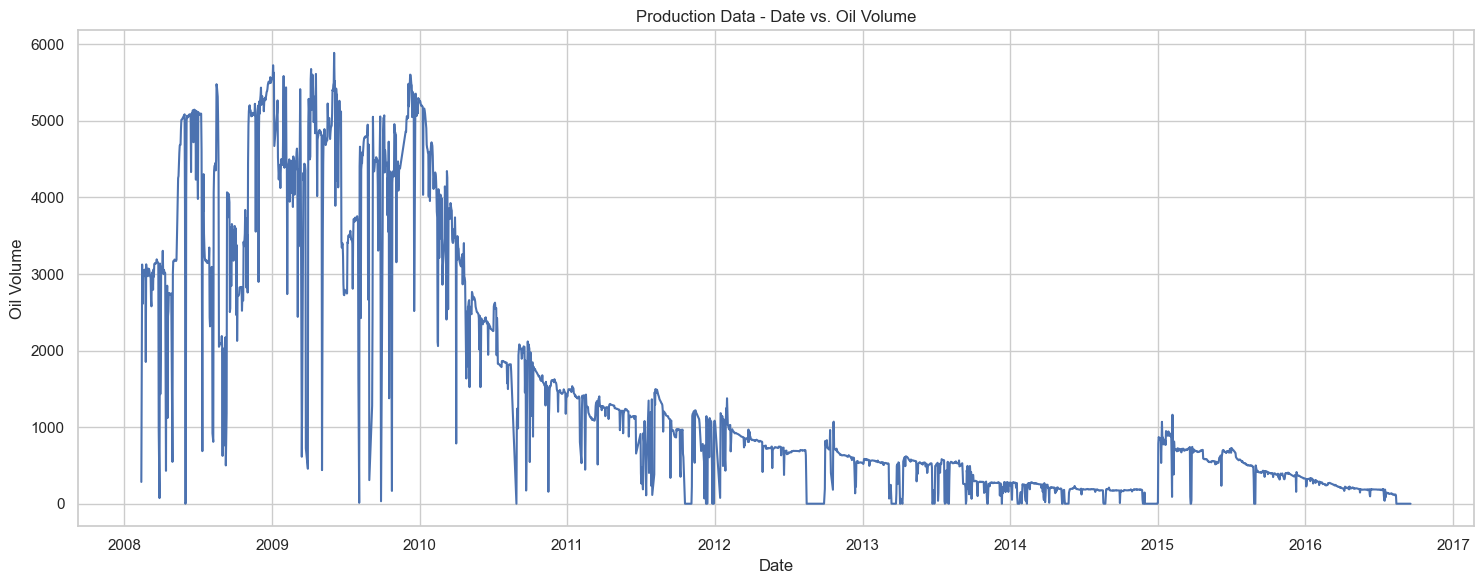

In [23]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
sns.lineplot(data=data, x='DATEPRD', y='BORE_OIL_VOL',errorbar=None)
plt.xlabel('Date')
plt.ylabel('Oil Volume')
plt.title('Production Data - Date vs. Oil Volume')
plt.tight_layout()
plt.show()

#### 数据预处理

我们使用`sklearn`的`MinMaxScaler`来缩放特征。

如果为气体或水建模，请确保将`BORE_OIL_VOL`替换为正确的术语。



In [24]:
tf.random.set_seed(42)
from sklearn.preprocessing import MinMaxScaler

columns_to_scale = ['ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL']
data_to_scale = data[columns_to_scale].copy()
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_to_scale)
data_scaled_df = pd.DataFrame(data_scaled, columns=columns_to_scale)

# Add the 'DATEPRD' column as the first column. Later, we will use it for plotting purpose.
data_scaled_df.insert(0, 'DATEPRD', data['DATEPRD'])

In [25]:
data_scaled_df

,DATEPRD,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL
0,NaT,0.460,0.978644,0.971263,0.719611,0.620908,0.144844,0.777839,0.176238,0.745028,0.048338
1,NaT,0.960,0.962689,0.980421,0.651296,0.548525,0.228330,0.880400,0.577278,0.722027,0.317507
2,NaT,0.900,0.939029,0.983889,0.650306,0.421708,0.312500,0.828179,0.786705,0.645493,0.530524
3,NaT,0.926,0.945627,0.983669,0.646602,0.175352,0.285189,0.850847,0.757051,0.678770,0.442930
4,NaT,0.960,0.940140,0.984220,0.645418,0.412548,0.302279,0.840679,0.773517,0.663528,0.518248
...,...,...,...,...,...,...,...,...,...,...,...
2988,2011-02-08,0.000,0.000000,0.000000,0.000000,0.664855,0.009929,0.000000,0.000000,0.000102,0.000000
2989,2011-02-09,0.000,0.000000,0.000000,0.000000,0.664848,0.009730,0.000000,0.000000,0.000127,0.000000
2990,2011-02-10,0.000,0.000000,0.000000,0.000000,0.664856,0.009778,0.000000,0.000000,0.000191,0.000000
2991,2011-02-11,0.000,0.000000,0.000000,0.000000,0.664852,0.009610,0.000000,0.000000,0.000199,0.000000


数据的值都在0到1之间。

接下来是最重要的部分：

在LSTM中，我们输入前一个时间步长的数据，并预测当前时间步长的目标。在我们的例子中，我们将输入前一个时间步长（前一天）的所有特征，包括石油产量，我们将预测当前时间步长（今天）的石油产量。

因此，让我们将数据分为特征和目标（标签）。稍后，我们将使用 `windowed_dataset` 函数来获取前一时间步的特征和当前时间步的目标。 

如果您是针对气体或水进行建模，请务必用正确的术语替换“BORE_OIL_VOL”。

In [26]:
features = data_scaled_df[['ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL']]
target = data_scaled_df[['BORE_OIL_VOL']]


LSTM 需要 Numpy 数据类型，因此下面的代码会将我们的数据（DataFrame 类型）转换为 Numpy 数据类型。

In [27]:
features = features.to_numpy()
target = target.to_numpy()

现在我们将使用 `sklearn` 将数据分为 70% 的训练集、15% 的验证集和 15% 的测试集。

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(features, target, test_size=0.3, shuffle=False)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, shuffle=False)
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

print("Number of samples in train set:", X_train.shape[0])
print("Number of samples in validation set:", X_val.shape[0])
print("Number of samples in test set:", X_test.shape[0])

Number of samples in train set: 2095
Number of samples in validation set: 449
Number of samples in test set: 449




可视化一下数据拆分后的结果。

C:\Users\luofei\AppData\Local\Temp\ipykernel_9008\1539548707.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sns.lineplot(x=data['DATEPRD'][:Y_train.shape[0]].ravel(), y=Y_train.ravel(), label='Train', errorbar=None)
C:\Users\luofei\AppData\Local\Temp\ipykernel_9008\1539548707.py:4: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sns.lineplot(x=data['DATEPRD'][Y_train.shape[0]:Y_train.shape[0] + Y_val.shape[0]].ravel(), y=Y_val.ravel(), label='Val', errorbar=None)
C:\Users\luofei\AppData\Local\Temp\ipykernel_9008\1539548707.py:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sns.lineplot(x=data['DATEPRD'][Y_train.shape[0] + Y_v

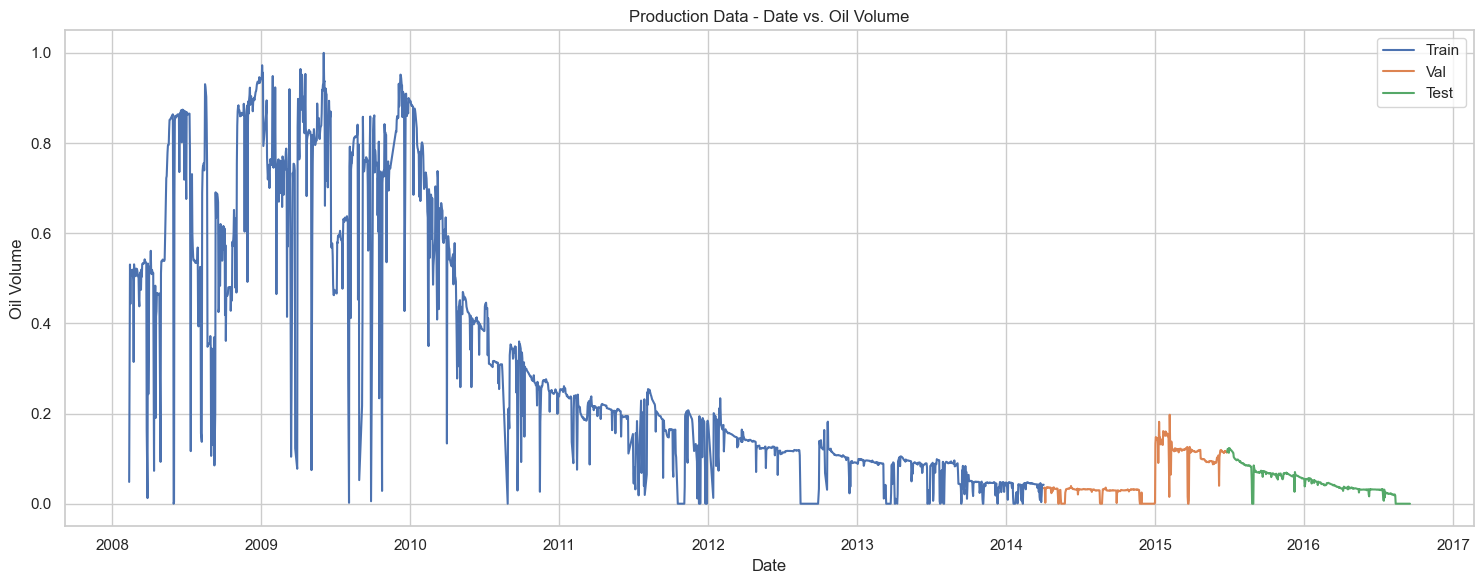

In [29]:
plt.figure(figsize=(15, 6))

sns.lineplot(x=data['DATEPRD'][:Y_train.shape[0]].ravel(), y=Y_train.ravel(), label='Train', errorbar=None)
sns.lineplot(x=data['DATEPRD'][Y_train.shape[0]:Y_train.shape[0] + Y_val.shape[0]].ravel(), y=Y_val.ravel(), label='Val', errorbar=None)
sns.lineplot(x=data['DATEPRD'][Y_train.shape[0] + Y_val.shape[0]:Y_train.shape[0] + Y_val.shape[0] + Y_test.shape[0]].ravel(), y=Y_test.ravel(), label='Test', errorbar=None)

plt.xlabel('Date')
plt.ylabel('Oil Volume')
plt.title('Production Data - Date vs. Oil Volume')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 3 LSTM建模

### 3.1 构造时间窗数据

将时序数据转换为适合时间序列预测任务的窗口化数据集.这是长短期记忆网络（LSTM）的主要概念。 

我们的数据将会是： 
* 前一天的所有特征（包括石油产量），当天的目标值（石油产量） 
* 然后是当天的所有特征，次日的目标值（石油产量）
* 以此类推……

In [30]:
def windowed_dataset(features, target, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((features, target))
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda x, y: tf.data.Dataset.zip((x.batch(window_size + 1), y.batch(window_size + 1))))
    dataset = dataset.map(lambda x, y: (x[:-1], y[1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

<details>
  <summary><font size="3" color="darkgreen"><b>Click here for Explanation</b></font></summary>
  
  Here's a step-by-step explanation of each part of the code:

`def windowed_dataset(features, target, window_size, batch_size):`
    This line defines a Python function named windowed_dataset that takes four arguments: features, target, window_size, and batch_size.

`dataset = tf.data.Dataset.from_tensor_slices((features, target))`
    This line creates a TensorFlow dataset using tf.data.Dataset.from_tensor_slices. It takes two arguments, features and target, and creates a dataset where each element is a pair consisting of a feature and its corresponding target. This is a common way to create a dataset from arrays.

`dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)`
This line applies a windowing operation to the dataset. It divides the dataset into overlapping windows of size `window_size + 1,` where window_size is a parameter provided to the function. The `shift=1` argument means that the windows will shift by one element at a time, creating overlapping windows. `drop_remainder=True` ensures that windows with fewer than `window_size + 1` elements are dropped.

`dataset = dataset.flat_map(lambda x, y: tf.data.Dataset.zip((x.batch(window_size + 1), y.batch(window_size + 1))))`
This line flattens the nested dataset created by the window operation. It uses flat_map to convert each window into a new dataset using a lambda function. Within this lambda function, x and y represent a window of features and target, respectively. `tf.data.Dataset.zip` is used to create pairs of (features_window, target_window), where each window contains `window_size + 1` elements. This essentially stacks the elements of each window together.

`dataset = dataset.map(lambda x, y: (x[:-1], y[1:]))`
This line maps a lambda function over the dataset to extract the input-output pairs for training. It takes each pair (features_window, target_window) and returns a new pair (input_sequence, target_sequence) where input_sequence is all elements of features_window except the last one `(x[:-1])`, and target_sequence is all elements of target_window except the first one `(y[1:])`. This prepares the data for a sequence prediction task where the model predicts the next element in a sequence based on the previous elements.

`dataset = dataset.batch(batch_size).prefetch(1)`
This line batches the dataset into mini-batches of size batch_size. Batching is commonly used in machine learning to process data in smaller chunks. The `prefetch(1)` operation prefetches one batch asynchronously to improve data loading efficiency.
return dataset

Finally, the function returns the prepared dataset, which is ready to be used for training a machine learning model.
</details>

将上述函数应用于我们的数据。

In [31]:
tf.random.set_seed(42)
window_size = 5
batch_size = 32
train_set = windowed_dataset(X_train, Y_train, window_size, batch_size)
val_set = windowed_dataset(X_val, Y_val, window_size, batch_size)
test_set = windowed_dataset(X_test, Y_test, window_size, batch_size)

查看应用窗口函数后我们的特征和目标的形状。

In [32]:
train_iterator = iter(train_set)
first_element = next(train_iterator)
features_shape = first_element[0].shape
target_shape = first_element[1].shape

print("Features shape:", features_shape)
print("Target shape:", target_shape)

Features shape: (32, 5, 10)
Target shape: (32, 5, 1)


The shape of **input** is **`(batch_size, window_size, features)`**  
The shape of **output** is **`(batch_size, window_size, target)`**

- `batch_size` is 32, which means we process 32 samples simultaneously.
- `window_size` is 5, indicating that each sample spans 5 time steps or days.
- `features` is 10, representing the number of input data points at each time step.
- `target` is 1, representing oil production for each time step.

To provide a clearer understanding, let's examine the data for the first batch. Run the below cell to see:

- We have 5 time steps (5 days), each consisting of 10 input data points (features) and 1 target value.
- Note that out of 10 input data, the last one is the oil production of the previous day.
- **You can observe that the target (oil production) for day 1 is become an input for day 2.**
- **Target for day 2 is become an input for day 3 and this pattern continues for subsequent days.**

In [33]:
first_sample = (first_element[0][0], first_element[1][0])

for day in range(len(first_sample[0])):
    print(f"\033[1;34mDay {day + 1} Data:\033[0m")
    print(f"Input data for day {day + 1}: {first_sample[0][day]}")
    print(f"Target (oil production) for day {day + 2}: {first_sample[1][day]}")
    print()

Day 1 Data:
Input data for day 1: [0.46       0.97864427 0.97126284 0.71961053 0.62090818 0.14484431
 0.77783947 0.17623791 0.74502803 0.04833843]
Target (oil production) for day 2: [0.31750695]

Day 2 Data:
Input data for day 2: [0.96       0.96268884 0.98042132 0.65129648 0.54852549 0.22832986
 0.8803996  0.57727789 0.72202698 0.31750695]
Target (oil production) for day 3: [0.53052377]

Day 3 Data:
Input data for day 3: [0.9        0.93902947 0.9838889  0.65030582 0.42170758 0.31249966
 0.82817946 0.78670451 0.64549255 0.53052377]
Target (oil production) for day 4: [0.44293043]

Day 4 Data:
Input data for day 4: [0.926      0.94562662 0.98366927 0.64660201 0.17535249 0.2851893
 0.85084674 0.75705139 0.67877023 0.44293043]
Target (oil production) for day 5: [0.51824769]

Day 5 Data:
Input data for day 5: [0.96       0.94013964 0.9842203  0.64541839 0.41254845 0.30227902
 0.84067882 0.77351717 0.66352757 0.51824769]
Target (oil production) for day 6: [0.50650145]



### 3.2 定义LSTM模型

在尝试了不同的架构后，我发现下面的架构给出了最好的结果。

In [34]:
def LSTM_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(128,return_sequences=True),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1)
    ])

    return model

### 3.3 训练模型

我使用了 TensorFlow 中的 `EarlyStopping` 来在验证数据集上未见显著改进时提前终止训练。 下面的单元格可能需要 10 分钟到 1 小时，具体取决于您的 GPU 或 CPU。

In [35]:
tf.random.set_seed(42)

model = LSTM_model()
epochs = 1000
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=125, restore_best_weights=True)
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss='mean_squared_error', optimizer=optimizer)

history = model.fit(
    train_set,
    epochs=epochs,
    validation_data=val_set,
    shuffle=False,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/1000
     63/Unknown 5s 12ms/step - loss: 0.1667

c:\Users\luofei\miniconda3\envs\tf_env\lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.1623 - val_loss: 0.0141
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0773 - val_loss: 0.0081
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0619 - val_loss: 0.0062
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0496 - val_loss: 0.0054
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0478 - val_loss: 0.0045
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0434 - val_loss: 0.0037
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0391 - val_loss: 0.0029
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0407 - val_loss: 0.0019
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0347 - val_loss: 0.0016
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0325 - val_loss: 0.0012
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0288 - val_loss: 8.3946e-04
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/s

模型训练完成，大约在 400 个周期时激活了`EarlyStopping`机制，额外节省了 600 个周期的数据。 

绘制训练损失和验证损失的图表。

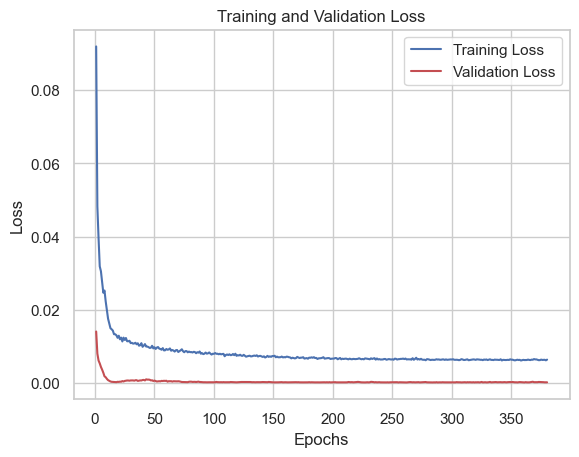

In [36]:
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3.4 预测测试集上的石油产量

In [37]:
predictions = model.predict(test_set)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step



下面的代码将 `X_test` 与预测数据连接起来，反转缩放，并将 `PREDICTED_OIL` 列添加到数据中。

In [38]:
df_pred = pd.concat([pd.DataFrame(X_test[:,1:][window_size:]),pd.DataFrame(predictions)], axis = 1)
rev_trans = scaler.inverse_transform(df_pred)
df_final = data.iloc[-predictions.shape[0]:].copy()
df_final['PREDICTED_OIL'] = rev_trans[:,-1]

#### 绘制预测数据和实际数据

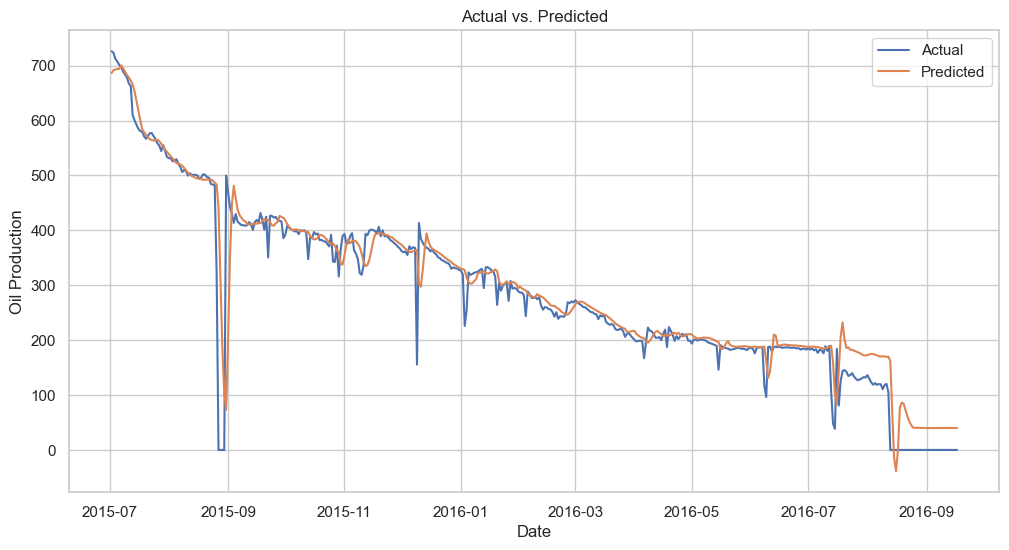

In [39]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_final, x='DATEPRD', y='BORE_OIL_VOL', label='Actual', errorbar=None)
sns.lineplot(data=df_final, x='DATEPRD', y='PREDICTED_OIL', label='Predicted', errorbar=None)
plt.xlabel('Date')
plt.ylabel('Oil Production')
plt.title('Actual vs. Predicted')
plt.legend()
plt.grid(True)
plt.show()

创建一个名为 `compare_data` 的数据框，其中包含 `DATEPRD`、`BORE_OIL_VOL` 和 `PREDICTED_OIL` 这三列，以便将实际数据值和预测数据值并排进行比较。

In [40]:
compare_data = df_final[['DATEPRD', 'BORE_OIL_VOL', 'PREDICTED_OIL']]
compare_data

,DATEPRD,BORE_OIL_VOL,PREDICTED_OIL
4523,2015-07-02,726.33,686.656042
4524,2015-07-03,723.42,691.822313
4525,2015-07-04,711.93,692.778594
4526,2015-07-05,707.58,694.288304
4527,2015-07-06,701.27,694.182742
...,...,...,...
4962,2016-09-13,0.00,40.022184
4963,2016-09-14,0.00,40.016041
4964,2016-09-15,0.00,40.015515
4965,2016-09-16,0.00,40.016656


### 3.5 计算预测性能指标 

以下是对这些性能指标的解释：

#### 1. 均方误差（MSE）
- **含义**：MSE 衡量模型预测值与真实值之间的平均平方误差。它对较大的误差更敏感，因为平方操作会放大这些误差的影响。
- **公式**：$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$
- **解释**：较低的 MSE 值表示模型的预测值更接近真实值。较高的 MSE 值表示模型存在较大的预测误差。由于它对大误差的敏感性，MSE 可以帮助你识别模型在某些样本上是否存在显著的预测偏差。

#### 2. 平均绝对误差（MAE）
- **含义**：MAE 衡量模型预测值与真实值之间的平均绝对误差。它以与原始数据相同的单位表示，因此更直观易懂。
- **公式**：$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$
- **解释**：MAE 表示模型预测值与真实值之间的平均绝对差异。较低的 MAE 值表示模型的预测值更接近真实值。与 MSE 相比，MAE 对异常值的敏感度较低，因此可以提供一个更稳健的误差度量。

#### 3. 均方根误差（RMSE）
- **含义**：RMSE 是 MSE 的平方根，它以与原始数据相同的单位表示，便于解释。它同样对较大的误差更敏感。
- **公式**：$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$
- **解释**：RMSE 提供了模型预测误差的标准差的估计。较低的 RMSE 值表示模型的预测值更接近真实值。与 MSE 类似，RMSE 对大误差更敏感，因此可以更好地反映模型在极端情况下的预测性能。

#### 4. 决定系数（R²）
- **含义**：R² 衡量模型对数据变异性的解释能力。它表示模型预测值与真实值之间的相关性强度。
- **公式**：$\text{R}^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$
- **解释**：
  - R² 的取值范围为 \([0, 1]\)，在某些情况下可能为负值（当模型预测效果比简单的平均值还差时）。
  - 较高的 R² 值（接近 1）表示模型对数据的解释能力较强，预测值与真实值之间的相关性较高。
  - 较低的 R² 值（接近 0 或负值）表示模型对数据的解释能力较弱，预测值与真实值之间的相关性较低。

### 总结
- **MSE**：对大误差敏感，适合用于优化和评估模型的整体性能。
- **MAE**：对异常值不敏感，适合用于需要更直观误差度量的场景。
- **RMSE**：易于解释，适合用于与原始数据单位一致的误差分析。
- **R²**：衡量模型的解释能力，适合用于比较不同模型的性能。

通过综合考虑这些指标，可以全面评估模型在测试集上的性能。每个指标都有其独特的视角，结合起来可以帮助你更好地理解模型的优点和不足。

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 假设 compare_data 是包含真实值和预测值的 DataFrame
# compare_data = df_final[['DATEPRD', 'BORE_OIL_VOL', 'PREDICTED_OIL']]

# 提取真实值和预测值
y_true = compare_data['BORE_OIL_VOL']
y_pred = compare_data['PREDICTED_OIL']

# 计算 MSE
mse = mean_squared_error(y_true, y_pred)
print(f"均方误差 (MSE): {mse}")

# 计算 MAE
mae = mean_absolute_error(y_true, y_pred)
print(f"平均绝对误差 (MAE): {mae}")

# 计算 RMSE
rmse = np.sqrt(mse)
print(f"均方根误差 (RMSE): {rmse}")

# 计算 R²
r2 = r2_score(y_true, y_pred)
print(f"决定系数 (R²): {r2}")

均方误差 (MSE): 2311.02638684235
平均绝对误差 (MAE): 22.85250712560808
均方根误差 (RMSE): 48.07313581245091
决定系数 (R²): 0.9081716490320051


## 4 改进工作

请尝试训练自己的模型，得到更好的预测效果。相关方法包括但不限于：


1. 不要只使用一个井的数据，而是使用全部数据集。
2. 尝试进行**超参数调整**，比如增加更多的轮次、层数等，以获得良好的匹配效果。
3. 使用**更为先进的时间序列预测模型**，包括但不限于`Attention + LSTM`,`脉冲神经网络（Spiking Neural Networks, SNNs）`,`KAN（Kolmogorov-Arnold Networks）`,`Transformer + 卡尔曼滤波（Kalman Filter）`,`傅里叶分析神经网络（Fourior Analysis Network）`, `扩散模型（Duffusion Model）`等。